In [2]:
#!pip install nltk
import nltk
#nltk.download("reuters")

import pandas as pd
from nltk.corpus import reuters
import numpy as np
import matplotlib.pyplot as plt 


In [70]:
reuters.categories("training/9865")

['barley', 'corn', 'grain', 'wheat']

In [27]:
reuters.fileids("barley")[50]

'training/9958'

## 1.	Use appropriate NLTK coding to visualize the number of documents per category in the training set. Is the dataset class balanced? Motivate your answer.

Go through categories and get number of documents in each. Then put them in dataframe.

In [37]:
frame = {"category":[], "Num_docs":[]}          # initialize frame with empty lists
for i in reuters.categories():                  # iterate through categories
    documents = len(reuters.fileids(i))         # get number of documents/category
    #print(f"{i} has {documents} documents")
    frame["category"].append(i)                 # Append category name and
    frame["Num_docs"].append(documents)         # number of documents on approppriate column

data=pd.DataFrame(data=frame)                   # make dataframe fr

In [38]:
data

,category,Num_docs
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


In [51]:
data2=data.rename(index=data["category"])

In [50]:
data

,category,Num_docs
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


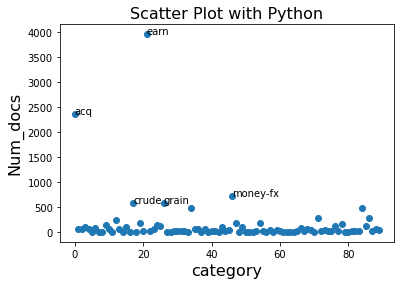

In [88]:

df = data.query('Num_docs >= 500')
# scatter plot with matplotlib in Python
plt.scatter(data.index, data.Num_docs, alpha=1)
for i in df.index:
    plt.annotate(data.iloc[i,0], (i,data.iloc[i,1]))

# set x-axis label and specific size
plt.xlabel('category',size=16)
# set y-axis label and specific size
plt.ylabel('Num_docs',size=16)
# set plot title with specific size
plt.title('Number of documents / category',size=16)
# save the plot as PNG file with dpi=150
#plt.savefig('Scatter_Plot_with_Matplotlib_in_Python.png', dpi=150
plt.show()